In [1]:
import jax
import jax.numpy as jnp
from approx_post.distributions import approx, joint, amortised
from approx_post import losses, optimisers
import seaborn as sns
import matplotlib.pyplot as plt
sns.set({'figure.facecolor':'white'})

In [2]:
def create_data(model, theta_min, theta_max, num_batch, noise_cov, prngkey):
    theta_vals = jnp.linspace(theta_min, theta_max, num_batch) # shape = (num_batch, dim_x)
    mean_vals = model(theta_vals).reshape(num_batch, -1) # shape = (num_batch, dim_theta)
    # Zero-mean samples:
    x_dim = mean_vals.shape[1]
    epsilon = jax.random.multivariate_normal(prngkey, mean=jnp.zeros(x_dim), cov=noise_cov, shape=(num_batch,)) # shape = (num_batch, dim_x)
    # Add each mean on:
    samples = mean_vals + epsilon # shape = (num_batch, x_dim)
    return samples

In [3]:
# First, let's define a model:
ndim = 1
model = lambda theta: theta**2
model_grad = jax.vmap(jax.vmap(jax.jacfwd(model), in_axes=0), in_axes=0)

In [4]:
prngkey = jax.random.PRNGKey(20)
theta_min, theta_max = 0, 5
num_batch = 100
noise_cov = 0.1*jnp.identity(ndim)
data = create_data(model, theta_min, theta_max, num_batch, noise_cov, prngkey)

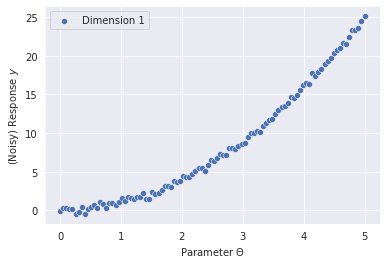

In [5]:
theta_vals = jnp.linspace(theta_min, theta_max, num_batch)
for i in range(ndim):
    sns.scatterplot(x=theta_vals, y=data[:,i], label=f"Dimension {i+1}")
plt.xlabel("Parameter $\Theta$")
plt.ylabel("(Noisy) Response $y$")
plt.show()

In [6]:
# Create Gaussian approximate distribution:
prngkey = jax.random.PRNGKey(20)
approx_dist = approx.Gaussian(ndim)
amortised_dist = amortised.NeuralNetwork(approx_dist, ndim, prngkey)

In [7]:
# Create Joint distribution from forward model:
prior_mean = jnp.zeros(ndim)
prior_cov = jnp.identity(ndim)
joint = joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)

In [8]:
prngkey = jax.random.PRNGKey(20)
loss = losses.ReverseKL(joint, use_reparameterisation=True)
optimiser = optimisers.Adam()
optimiser.fit(amortised_dist, loss, data, prngkey)

<class 'jax.interpreters.batching.BatchTracer'>


AttributeError: 'ShapedArray' object has no attribute 'tolist'

In [ ]:
jnp.diag(jnp.array([1.]))